In [1]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch
import pandas as pd
import numpy as np
import faiss
import os
import cv2

### EMBEDDINGS DE LAS IMÁGENES CON MODELO DE HUGGING FACE

Read paths

In [2]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

Transformation function

In [3]:
# Carga el extractor de características y el modelo
pretrained_vit_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
pretrained_vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [12]:
def create_vit_embedding(img):
    img = np.array(img)

    # Función para cargar y preparar la imagen
    def preprocess_image(image):
        inputs = pretrained_vit_feature_extractor(images=image, return_tensors="pt")
        return inputs

    # Genera el embedding de la imagen
    def get_image_embedding(image_path):
        inputs = preprocess_image(image_path)
        with torch.no_grad():
            outputs = pretrained_vit_model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # Usamos el embedding de la clase [CLS]
        return embedding
    
    return np.array(get_image_embedding(img), dtype=np.float32)

Application of the function

In [13]:
embeddings = []
dimension = 768

for path in paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = create_vit_embedding(img).reshape(dimension)
    embeddings.append(features)

Creation of the index

In [14]:
np.array(embeddings[0]).shape

(768,)

In [17]:
index = faiss.IndexFlatL2(dimension)

vectores = np.array(embeddings)

faiss.normalize_L2(vectores)

index.add(vectores)

In [18]:
faiss.write_index(index, "database/vit.index")

Test

In [19]:
# Evitar conflicto de OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Desactiva GPU en TensorFlow

Distances:  [[0.30626622 0.32254618 0.35793784 0.36104715 0.377593  ]]
Indices:  [[106 168 140 173 114]]


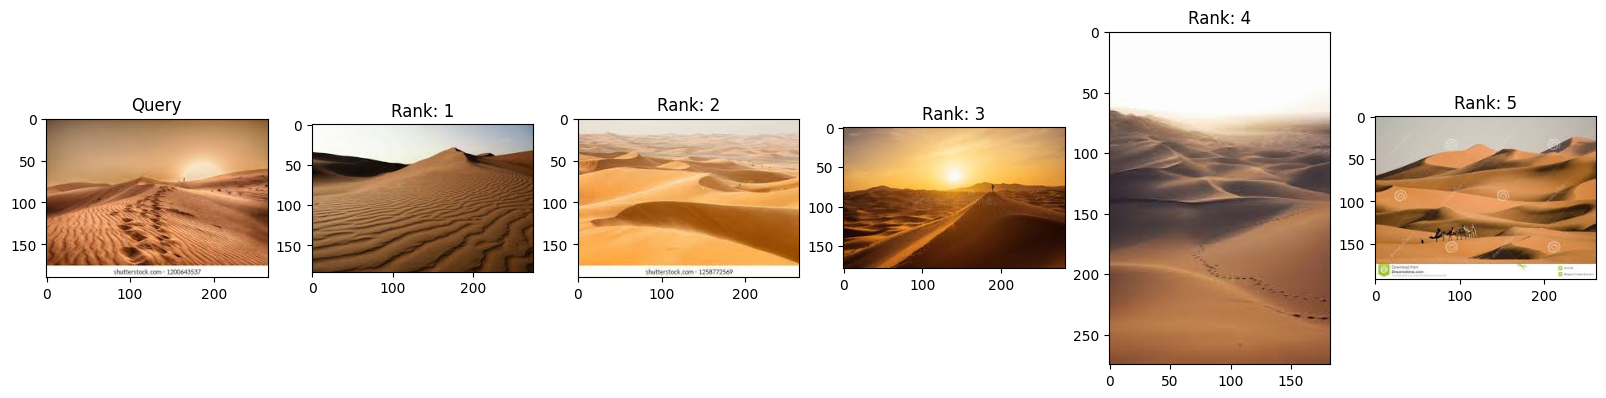

In [22]:
index = faiss.read_index("database/vit.index")

img_test = "images\Testing Data\Desert\Desert-Test (1).jpeg"

img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

query = create_vit_embedding(img).reshape(dimension)

query = np.array([query])

faiss.normalize_L2(query)

k = 5
distances, indices = index.search(query, k)

print("Distances: ", distances)
print("Indices: ", indices)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Query")

for i in range(5):
    img = cv2.imread(paths[indices[0][i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, i+2)
    plt.imshow(img)
    plt.title("Rank: " + str(i+1))

plt.show()